## Data

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from config import BASE_DIR
from notebooks.constants import NOT_HEB_BOOKS
from notebooks.text_processing import generate_corpus_df, add_sectarian_label, convert_df_to_by_book
from notebooks.text_processing import pre_process_corpus
from notebooks.notebooks_utils import generate_composition_to_book

matplotlib.rcParams['figure.figsize'] = (15, 10)


**Conditions**
1. Books greater then 300 words.
2. Hebrew books.
3. Each book divided into 100 words chunks.

So we have 202 scrolls that match our criteria (with 39 compositions).
Only 129 scrolls have composition label.

In [10]:
DATA_PATH = "data/text_and_starr_features_22_05_2024.csv"
df = pd.read_csv(DATA_PATH)
df = add_sectarian_label(df)

# Merge with the composition-to-book mapping and remove duplicates
composition_to_book = generate_composition_to_book().drop_duplicates(subset=['book'])
df = pd.merge(df, composition_to_book, on="book", how="left", validate="many_to_one")

# Filter out non-Hebrew books
df = df[~df["book"].isin(NOT_HEB_BOOKS)]

# Aggregate text by book
df_grouped = df.groupby("book")["text"].apply(' '.join).reset_index()

# Merge with additional book info and remove duplicates
book_info = df[["book", "composition", "section"]].drop_duplicates()
df_by_book = pd.merge(df_grouped, book_info, on="book", how="inner")

# Compute the number of words in each book
df_by_book["number_of_words"] = df_by_book['text'].str.split().apply(len)

# Filter books with at least 300 words
df_by_book = df_by_book[df_by_book["number_of_words"] >= 300]

# Get the list of books with enough words
books_with_enough_words = df_by_book["book"].tolist()

# Filter the original dataframe to keep only books with enough words
df_final = df[df["book"].isin(books_with_enough_words)]
df_final.to_csv("data/text_and_starr_features_filtered_data_22_05_2024.csv", index=False)
# Display the final dataframe
print(df_final.info())
df


<class 'pandas.core.frame.DataFrame'>
Index: 2991 entries, 0 to 4442
Data columns (total 25 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   book                                                                2991 non-null   object 
 1   sentence_path                                                       2991 non-null   object 
 2   text_lex                                                            2982 non-null   object 
 3   text                                                                2991 non-null   object 
 4   n_words_lex                                                         2991 non-null   int64  
 5   n_words                                                             2991 non-null   int64  
 6   construct to absolute nouns ratio                                   2991 non-null   float64
 7   construct nouns and 

,book,sentence_path,text_lex,text,n_words_lex,n_words,construct to absolute nouns ratio,construct nouns and adjectives percentage,noun to verb ratio,definite_article_percentage,...,aCr percentage,oM percentage,kya percentage,all conjunctions percentage,non-finite to finite verbs ratio,passive verb forms percentage,total word count,section,scroll,composition
0,CD,CD:1:1-1:12,שמע כל ידע צדק בין מעה אל ריב ל כל בר משפט עה ...,ועתה שמעו כל יודעי צדק ובינו במעשי אל כי ריב ל...,82,92,0.666667,0.110092,2.250000,0.917431,...,0.0,0.0,0.0,21.100917,0.333333,0.000000,109.0,sectarian_texts,CD,CD
1,CD,CD:1:12-2:1,אחרון עה דור אחרון עדה בגד הם סור דרך היא עת ה...,אחרונים את אשר עשה בדור אחרון בעדת בוגדים הם ס...,85,96,0.545455,0.114286,1.241379,4.761905,...,0.0,0.0,0.0,14.285714,0.705882,0.000000,105.0,sectarian_texts,CD,CD
2,CD,CD:2:1-2:10,כל המון מעה נדה פנה שמע אל כל בוא ברית גלה אזן...,את כל המונם ומעשיהם לנדה לפניו ועתה שמעו אלי כ...,79,94,0.481481,0.130841,2.222222,0.934579,...,0.0,0.0,0.0,17.757009,0.800000,1.869159,107.0,sectarian_texts,CD,CD
3,CD,CD:2:10-2:20,כל שנה עולם כל קום ל קריא שם יתר פליטה ארץ מלא...,לכל שני עולם ובכולם הקים לו קריאי שם למען התיר...,79,94,1.250000,0.205607,1.714286,0.934579,...,0.0,0.0,0.0,17.757009,0.615385,1.869159,107.0,sectarian_texts,CD,CD
4,CD,CD:2:20-3:8,בר היה חרבה גוע היה היה עה רצון שמר מצוה עה חר...,בשר אשר היה בחרבה כי גוע ויהיו כלא היו בעשותם ...,81,95,1.100000,0.103774,1.000000,1.886792,...,0.0,0.0,0.0,18.867925,0.217391,6.603774,106.0,sectarian_texts,CD,CD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445,Arugleviticus,Arugleviticus:fB+Cii:14-fB+Cii:16,מות נכה נפש בהמה שלם נפש תחת נפש,יומת ומכה נפש בהמה ישלמנה נפש תחת נפש,9,9,0.500000,0.083333,2.500000,0.000000,...,0.0,0.0,0.0,8.333333,1.000000,8.333333,12.0,NaN,NaN,NaN
4446,Xjoshua,Xjoshua:1:1-2:9,צוה חזק אמץ ערץ חתת עם יהוה אלהים כל הלך צוה י...,הלוא צויתיך חזק ואמץ אל תערץ ואל תחת כי עמך יה...,62,78,1.333333,0.044944,1.045455,13.483146,...,0.0,0.0,0.0,15.730337,0.466667,1.123596,89.0,NaN,NaN,NaN
4447,Xjudges,Xjudges:f1:1-f3_7i:5,הלך יהודה כנעני ישב חברון שם חברון פנה קרית אר...,וילך יהודה אל הכנעני הישב בחברון ושם חברון לפנ...,80,93,-1.000000,0.074074,1.791667,7.407407,...,0.0,0.0,0.0,23.148148,0.200000,0.000000,108.0,NaN,NaN,NaN
4448,Xjudges,Xjudges:f3_7i:5-f3_7ii:1,משך הר תבור לקח עם ערה אלף איש בן נפתלי בן זבו...,ומשכת בהר תבור ולקחת עמך עשרת אלפים איש מבני נ...,42,54,6.000000,0.093750,1.333333,1.562500,...,0.0,0.0,0.0,21.875000,0.090909,0.000000,64.0,NaN,NaN,NaN


## Pre processing

## Analysis

In [22]:
df_by_book["number_of_chars"] = df_by_book['text'].str.len()
df_by_book["number_of_words"] = df_by_book['text'].str.split().map(lambda x: len(x))
df_by_book["avg_word_length"] = df_by_book['text'].str.split().apply(lambda x: [len(i) for i in x]).map(
    lambda x: np.mean(x))


Books with the highest avg word length:

In [23]:
df_by_book.sort_values(by="avg_word_length", ascending=False)[["book", "avg_word_length"]].head(15)


,book,avg_word_length
406,4Q321a,4.864971
404,4Q320,4.852113
405,4Q321,4.847656
89,1QM,4.426585
503,4Q394,4.419028
657,4Q491,4.369184
514,4Q403,4.360927
506,4Q397,4.326291
21,11Q5,4.263258
545,4Q429,4.255000


In [24]:
df_by_book[df_by_book["book"] == "4Q321a"]["text"].to_list()

[' השנה הראשונה בארבעה בגמול באחד בראשון בחמשה בידעיה בשלושים בוא השנית ודוקו בששה במעוזיה בשבעה עשר בוא שבת בקוץ בשלושים בשני ודוקו באחד במלכיה בשבעה עשר בוא באחד באלישיב בתשעה ועשרים בשלישי ודוקו בשנים בישוע בששה עשר בוא בשלושה בבלגא בשמונה ועשרים ברביעי ודוקו בארבעה בחופה בחמשה עשר בוא בארבעה בפתחיה בשבעה ועשרים בחמישי ודוקו בחמשה בחזיר בארבעה עשר בוא בששה בדליה בשבעה ועשרים בששי ודוקו שבת בגמול בארבעה עשר בוא שבת בשעורים בחמשה ועשרים בשביעי ודוקו באחד בידעיה בשנים עשר בוא בשנים באביה בחמשה ועשרים בשמיני ודוקו בשלושה במימין  בשנים עשר בוא בשלושה ביקים בארבעה ועשרים בתשיעי ודוקו בארבעה בשכניה באחד עשר בוא בחמשה באמר בשלושה ועשרים בעשירי ודוקו בששה בישבאב בעשרה בוא בששה ביחזקאל בשנים ועשרים בעשתי עשר החודש ודוקו שבת בפתחיה בתשעה בוא באחד ביויריב בשנים ועשרים בשנים עשר החודש ודוקו בשנים בדליה בתשעה בוא השנית החודש הראשון בשנים במלכיה בעשרים בוא ודוקו בשלושה בחרים בשבעה בוא בארבעה בישוע בעשרים בשני ודוקו בחמשה בקוץ בשבעה בוא בחמשה בחופה בתשעה עשר בשלישי ודוקו בששה באלישיב בששה בוא שבת ב

Text(0.5, 1.0, 'Average word length')

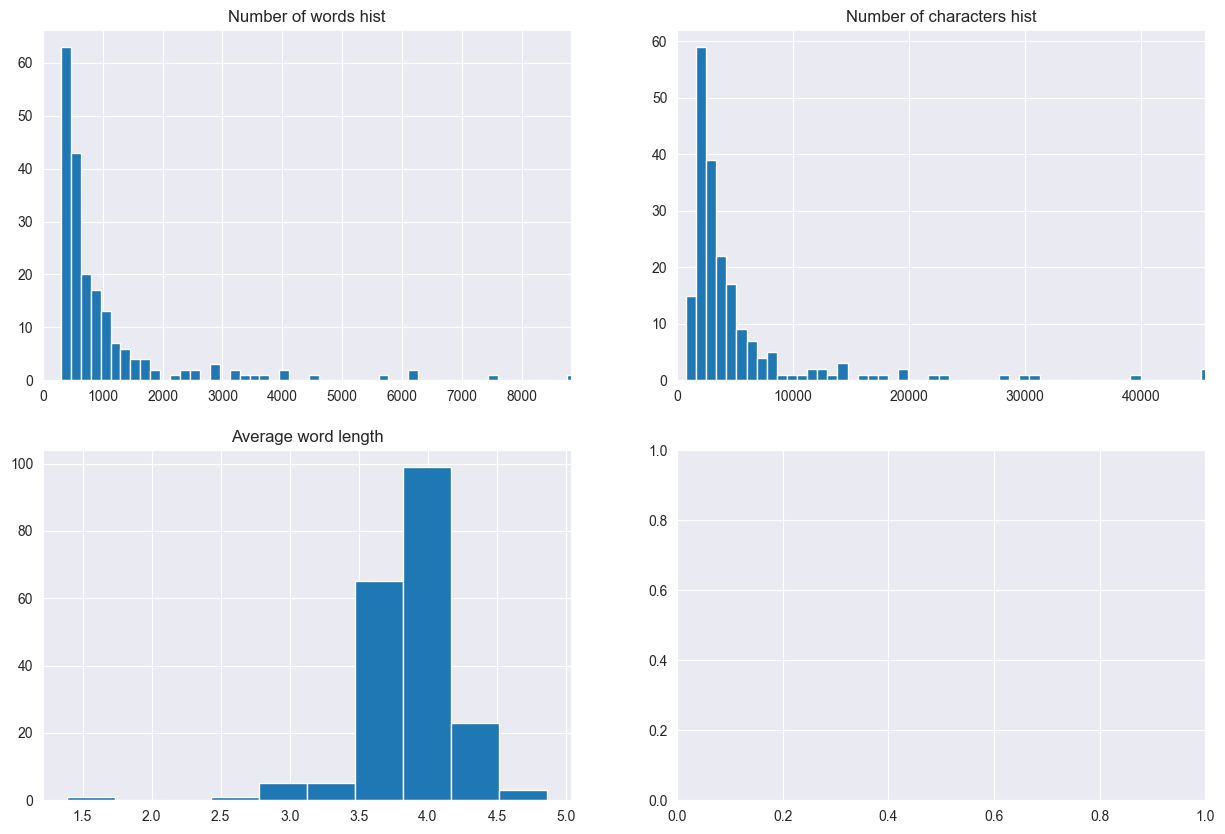

In [25]:
fig, ax = plt.subplots(2, 2)
df_by_book["number_of_words"].hist(ax=ax[0, 0], bins=100)
df_by_book["number_of_chars"].hist(ax=ax[0, 1], bins=100)
ax[0, 0].set_xlim(0, df_by_book["number_of_words"].quantile(0.99))
ax[0, 1].set_xlim(0, df_by_book["number_of_chars"].quantile(0.99))
df_by_book["avg_word_length"].hist(ax=ax[1, 0])
ax[0, 0].set_title("Number of words hist")
ax[0, 1].set_title("Number of characters hist")
ax[1, 0].set_title("Average word length")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yonatanlou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 1.0, 'Top 20 stop words in corpus')

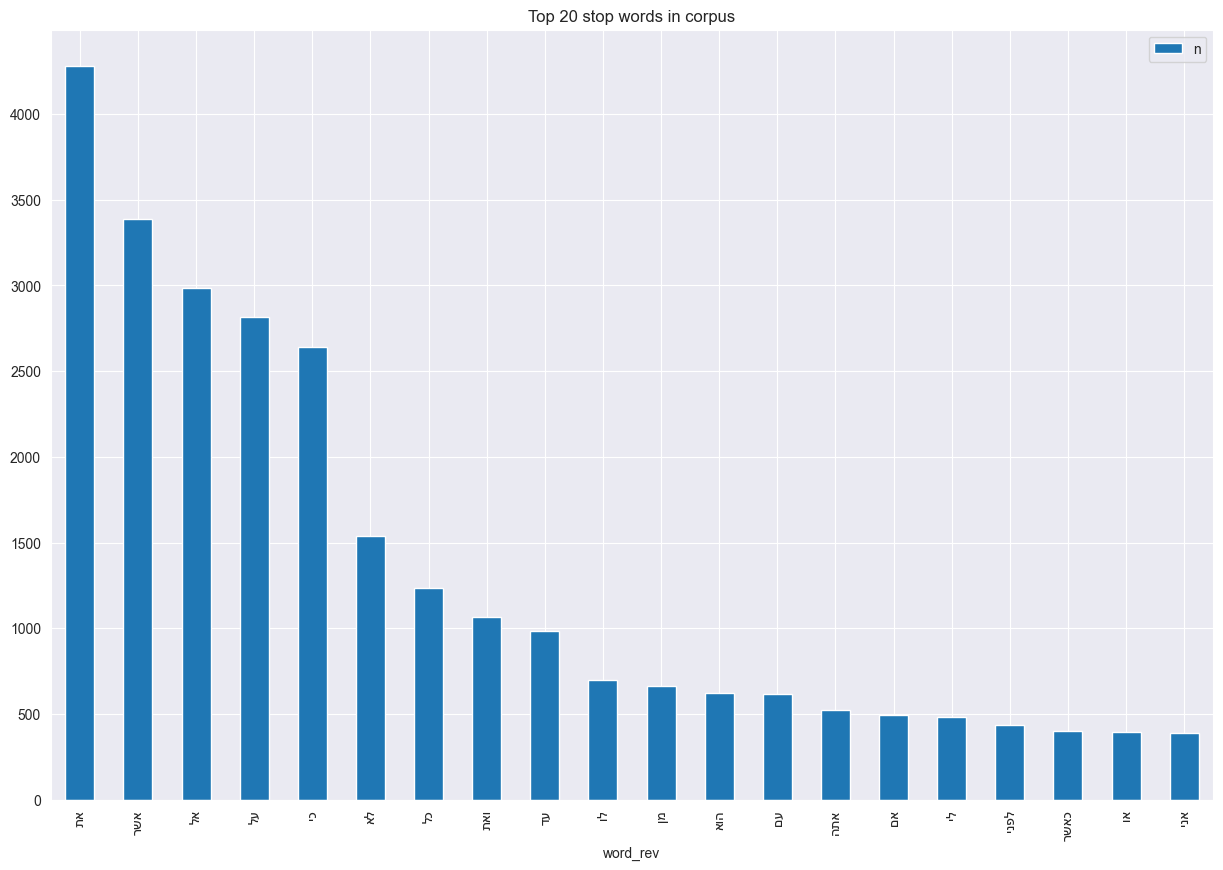

In [26]:
from collections import defaultdict
nltk.download('stopwords')
stop_words = set(stopwords.words('hebrew'))
corpus = []
words = df_by_book["text"].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
stop_words_dist = pd.DataFrame([dic]).T.reset_index().rename(columns={0: "n", "index": "word"})
stop_words_dist["word_rev"] = stop_words_dist["word"].str[::-1]
stop_words_dist = stop_words_dist.set_index("word_rev")
stop_words_dist.sort_values(by="n", ascending=False).head(20).plot(kind="bar")
plt.title("Top 20 stop words in corpus")

<Axes: >

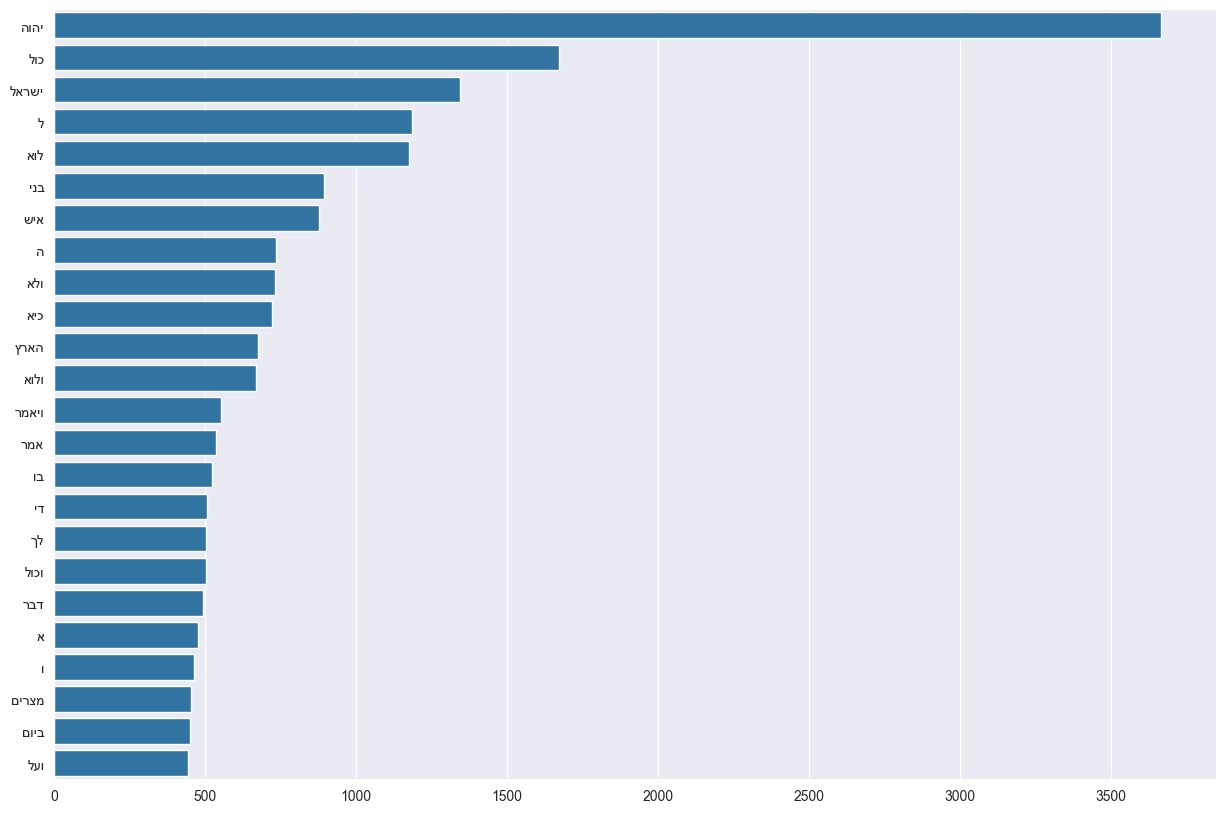

In [27]:
from collections import Counter

corpus = []
words = df_by_book["text"].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]
corpus_no_punc = [word for word in corpus if word != "."]
counter = Counter(corpus_no_punc)
most = counter.most_common()

import seaborn as sns

x, y = [], []
for word, count in most[:40]:
    if (word not in stop_words):
        x.append(word[::-1])
        y.append(count)

sns.barplot(x=y, y=x)

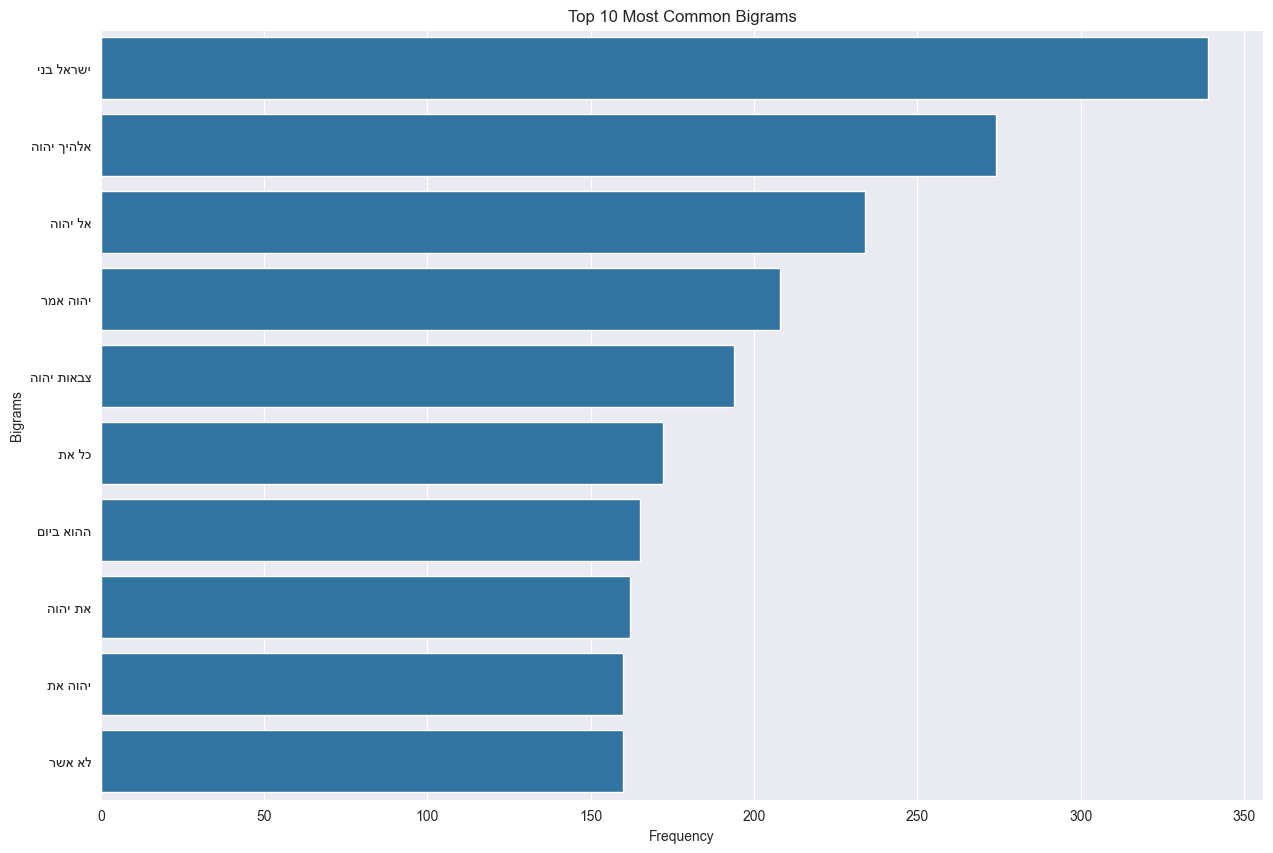

In [28]:
from nltk.util import ngrams
from collections import Counter


def most_common_ngram(words, n=2):
    # Tokenize the corpus into words

    # Generate n-grams
    n_grams = ngrams(words, n)

    # Count and find the most common n-gram
    ngram_freq = Counter(n_grams)
    most_common = ngram_freq.most_common()  # Returns the most common n-gram and its frequency
    return most_common


corpus_no_punc_rev = [word[::-1] for word in corpus if word != "."]


def plot_ngram(words, k, n):
    top_n_bigrams = most_common_ngram(words, k)[:n]
    bigrams, counts = map(list, zip(*top_n_bigrams))
    bigrams = [' '.join(bigram) for bigram in bigrams]  # Convert tuple to string for better readability on plot

    sns.barplot(x=counts, y=bigrams)
    plt.xlabel('Frequency')
    plt.ylabel('Bigrams')
    plt.title('Top 10 Most Common Bigrams')
    plt.show()


plot_ngram(corpus_no_punc_rev, 2, 10)


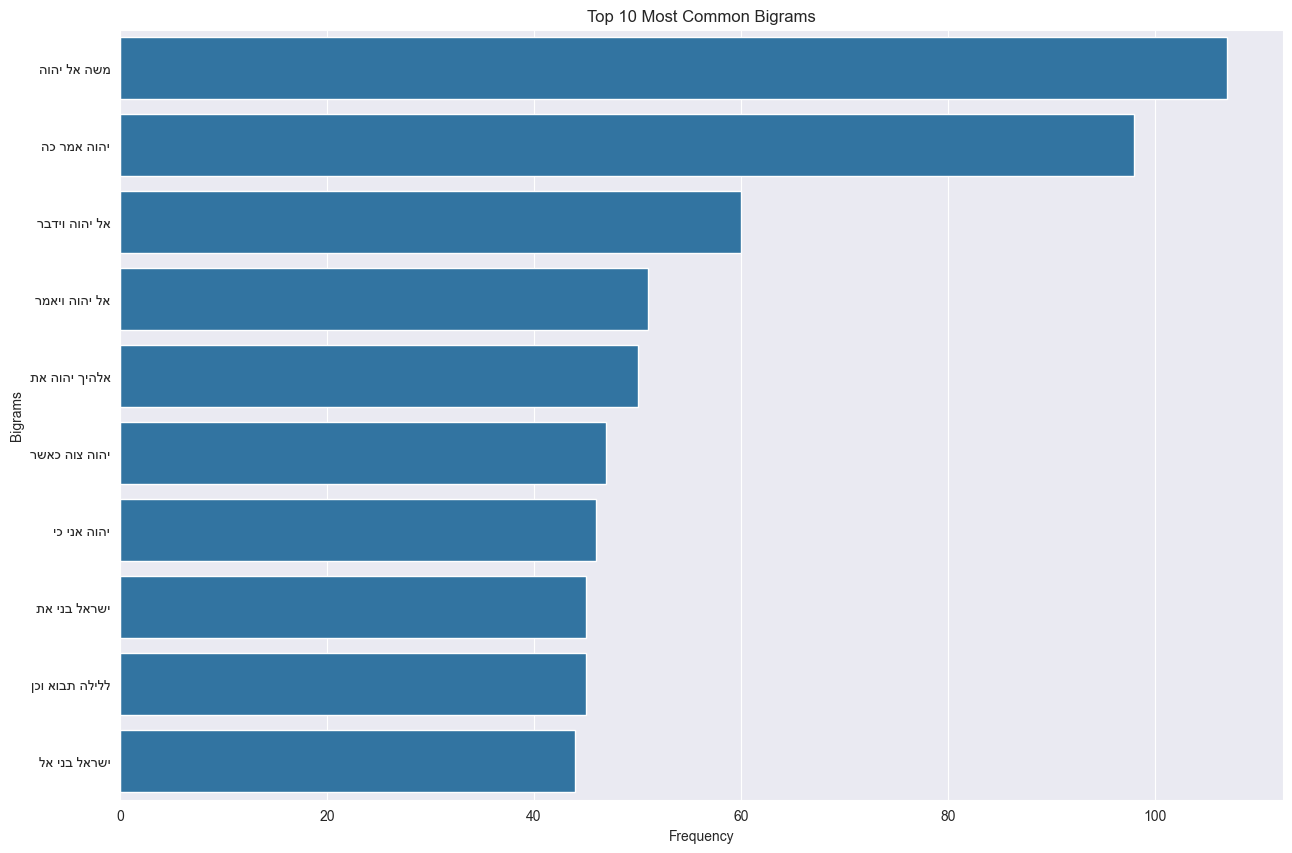

In [29]:
plot_ngram(corpus_no_punc_rev, 3, 10)

### Most correlated books

In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import Levenshtein
import numpy as np
from scipy.stats import spearmanr
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel
import torch

def plot_heatmap(similarity_df, vectorizer_type, similarity_metric):
    similarity_sums = similarity_df.sum(axis=1)
    sorted_books = similarity_sums.sort_values(ascending=True).index
    
    sorted_similarity_df = similarity_df.loc[sorted_books, sorted_books]
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_similarity_df, cmap='coolwarm', linewidths=.5, annot=False)
    plt.title('Sorted Book Similarity Heatmap (vectorizer: {}, similarity: {})'.format(vectorizer_type, similarity_metric))
    plt.show()

def compute_similarity(df, text_column='text', book_column='book', vectorizer_type='tfidf', similarity_metric='cosine', to_plot=False):
    
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(df[text_column])
    elif vectorizer_type == 'count':
        vectorizer = CountVectorizer(ngram_range=(3, 3), analyzer='char')
        tfidf_matrix = vectorizer.fit_transform(df[text_column])
    elif vectorizer_type == 'bert':
        tokenizer = AutoTokenizer.from_pretrained('onlplab/alephbert-base')
        model = AutoModel.from_pretrained('onlplab/alephbert-base')
        
        def bert_embed(texts):
            inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            return embeddings.cpu().numpy()
        
        tfidf_matrix = bert_embed(df[text_column].tolist())
    else:
        raise ValueError("Unsupported vectorizer type. Use 'tfidf', 'count', or 'bert'.")
    
    # Calculate similarity matrix
    if similarity_metric == 'cosine':
        similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    elif similarity_metric == 'euclidean':
        similarity_matrix = euclidean_distances(tfidf_matrix, tfidf_matrix)
        similarity_matrix = np.max(similarity_matrix) - similarity_matrix  # Convert to similarity
    elif similarity_metric == 'levenshtein':
        n = len(df)
        similarity_matrix = np.zeros((n, n))
        for i in tqdm(range(n), desc="levenshtein"):
            for j in range(n):
                if i != j:
                    similarity_matrix[i, j] = Levenshtein.distance(df.iloc[i][text_column], df.iloc[j][text_column])
        similarity_matrix = np.max(similarity_matrix) - similarity_matrix
    elif similarity_metric == 'spearman':
        tfidf_array = tfidf_matrix.toarray() if vectorizer_type != 'bert' else tfidf_matrix
        n = len(df)
        similarity_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    corr, _ = spearmanr(tfidf_array[i], tfidf_array[j])
                    similarity_matrix[i, j] = corr
    else:
        raise ValueError("Unsupported similarity metric. Use 'cosine', 'euclidean', 'levenshtein', or 'spearman'.")
    
    np.fill_diagonal(similarity_matrix, 0)

    # Normalize the similarity matrix
    if similarity_metric in ['cosine', 'spearman']:
        normalized_similarity_matrix = similarity_matrix  # These metrics are already between -1 and 1
    else:
        normalized_similarity_matrix = (similarity_matrix - np.mean(similarity_matrix[similarity_matrix != 0])) / np.std(similarity_matrix[similarity_matrix != 0])
    
    # Create a DataFrame for the similarity matrix
    similarity_df = pd.DataFrame(normalized_similarity_matrix, index=df[book_column], columns=df[book_column])
    
    if to_plot:
        plot_heatmap(similarity_df, vectorizer_type, similarity_metric)
        
    return similarity_df

def save_similarity_matrices(df, text_column='text', book_column='book'):
    vectorizer_types = ['tfidf', 'count', 
                        # 'bert'
                        ]
    similarity_metrics = ['cosine', 
                          # 'euclidean', 'levenshtein', 
                          'spearman'
                          ]
    similarity_matrices = {}
    
    for vectorizer in tqdm(vectorizer_types, desc="Vectorizers"):
        for metric in tqdm(similarity_metrics, desc="Metrics", leave=False):
            similarity_df = compute_similarity(df, text_column, book_column, vectorizer, metric)
            similarity_matrices[f'{vectorizer}_{metric}'] = similarity_df
    
    return similarity_matrices

def analyze_matrices(similarity_matrices):
    matrix_values = np.array([matrix.values for matrix in similarity_matrices.values()])
    mean_matrix = np.mean(matrix_values, axis=0)
    std_matrix = np.std(matrix_values, axis=0)
    
    sample_matrix = list(similarity_matrices.values())[0]
    mean_df = pd.DataFrame(mean_matrix, index=sample_matrix.index, columns=sample_matrix.columns)
    std_df = pd.DataFrame(std_matrix, index=sample_matrix.index, columns=sample_matrix.columns)
    
    significant_correlations = []
    for i in range(mean_df.shape[0]):
        for j in range(i+1, mean_df.shape[1]):
            mean_value = mean_df.iloc[i, j]
            std_value = std_df.iloc[i, j]
            z_value = mean_value / std_value if std_value != 0 else 0
            p_value = 1 - np.abs(z_value)
            significant_correlations.append((mean_df.index[i], mean_df.columns[j], mean_value, std_value, z_value, p_value))
    
    return mean_df, std_df, significant_correlations

# Example usage


# Compute and analyze similarity matrices
similarity_matrices = save_similarity_matrices(df_by_book.sort_values(by="number_of_words",ascending=False), text_column='text', book_column='book')
mean_df, std_df, significant_correlations = analyze_matrices(similarity_matrices)
corr_stats = pd.DataFrame(significant_correlations, columns=["book1","book2","mean", "std_", "z_value","p_value"])


Vectorizers:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

In [135]:
most_correlated_books = corr_stats[(np.abs(corr_stats["p_value"])<=0.2) & (corr_stats["mean"]>=corr_stats["mean"].quantile(0.5))].sort_values(by="mean", ascending=False)
most_correlated_books

,book1,book2,mean,std_,z_value,p_value
1718,1QM,4Q397,0.311323,0.264186,1.178424,-0.178424
7043,4Q491,4Q397,0.305227,0.255978,1.192397,-0.192397
146,1Qisaa,4Q397,0.300683,0.254409,1.181889,-0.181889
7013,4Q491,4Q385a,0.292043,0.243386,1.199916,-0.199916
8318,4Q55,4Q429,0.290412,0.242313,1.198499,-0.198499
17295,4Q73,4Q387,0.284187,0.236919,1.199512,-0.199512
552,11Q19,4Q429,0.282455,0.238351,1.185035,-0.185035
6313,4Q511,4Q59,0.280771,0.235456,1.192456,-0.192456
3956,4Q57,4Q397,0.276532,0.236360,1.169963,-0.169963
3226,4Q56,4Q397,0.275648,0.234619,1.174877,-0.174877


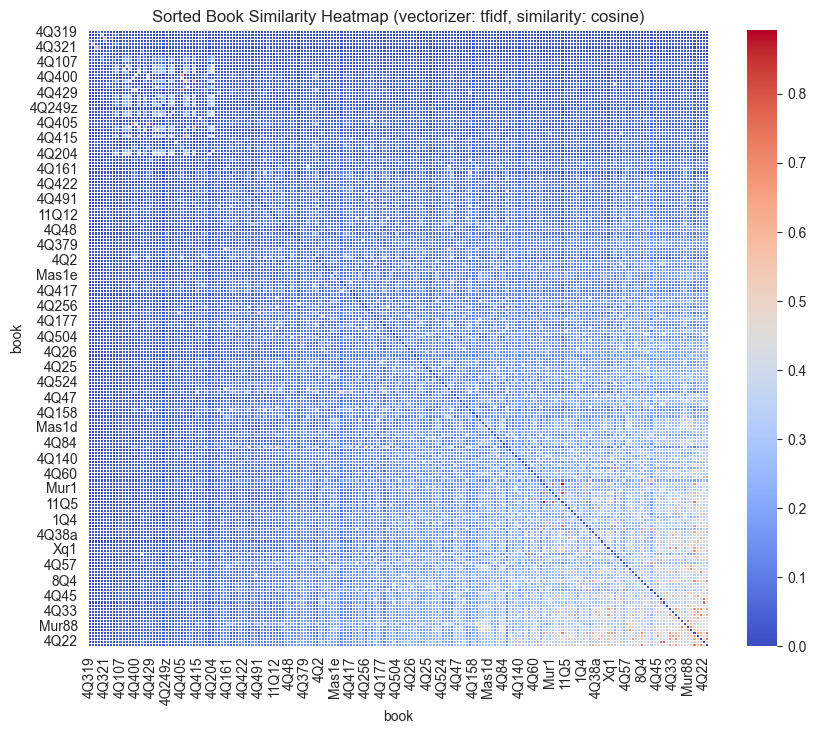

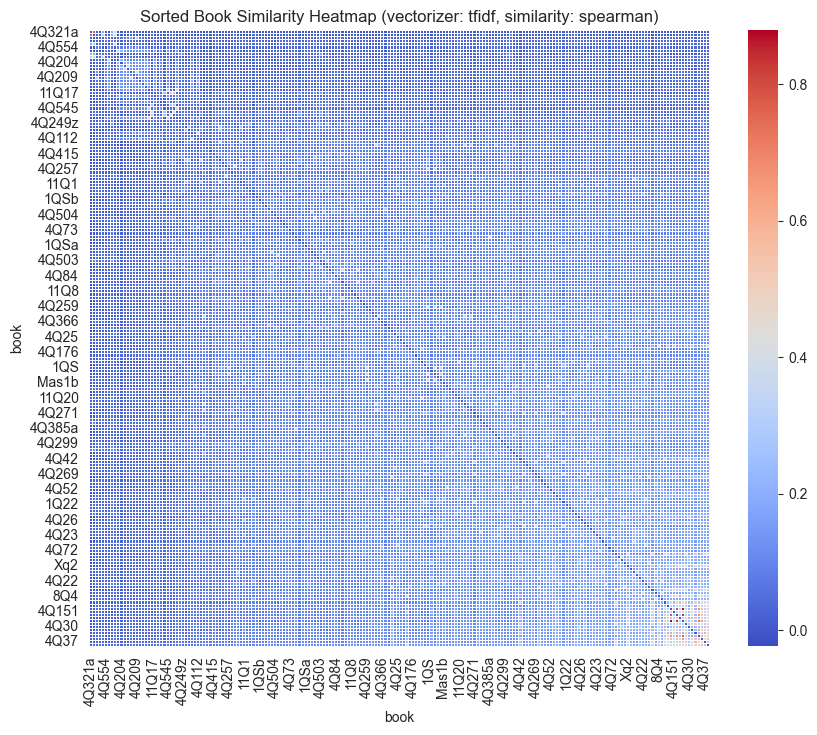

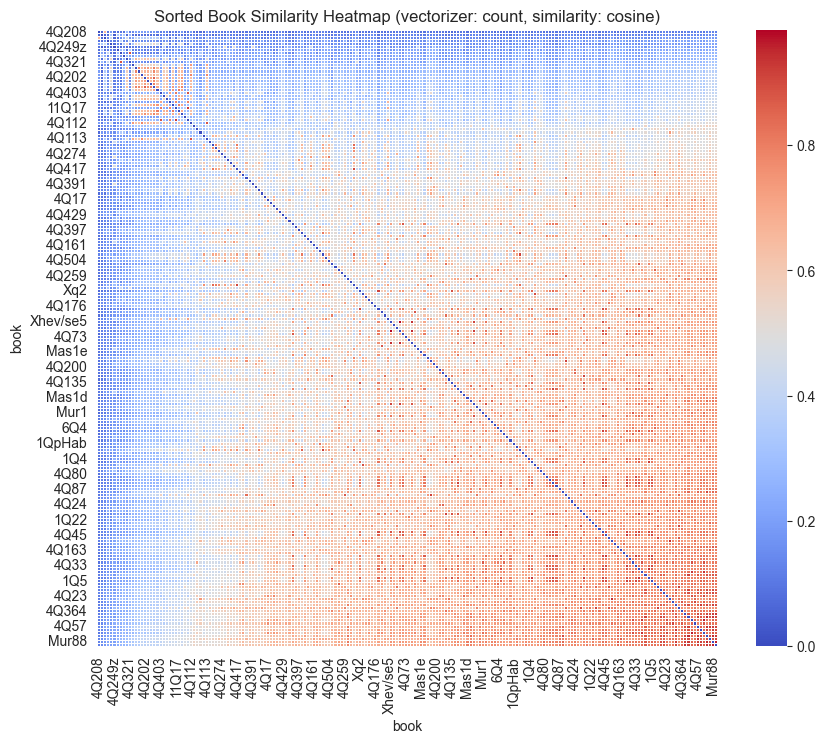

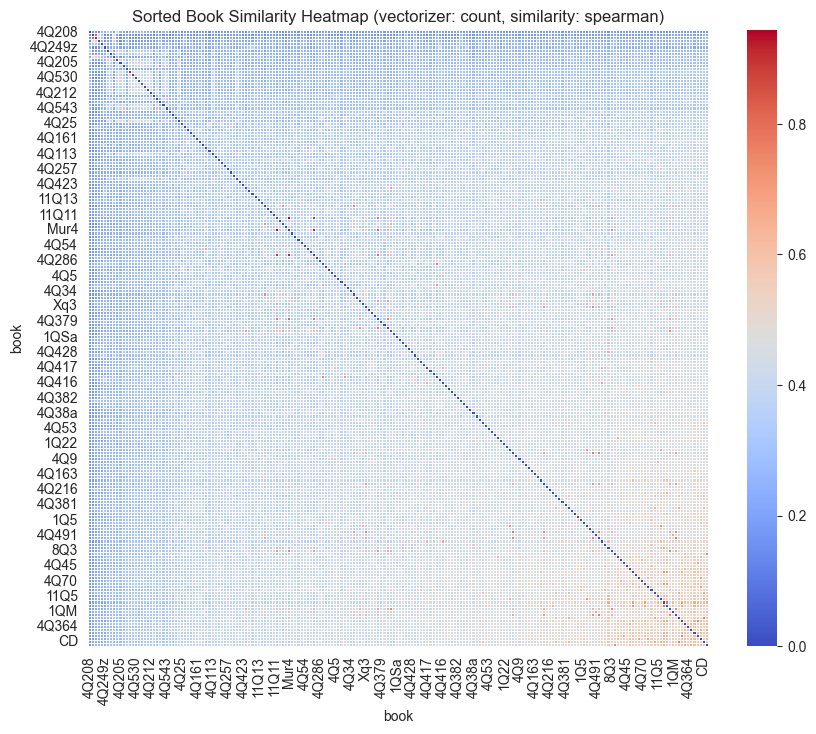

In [136]:
def plot_heatmap(similarity_df, vectorizer_type, similarity_metric):
    similarity_sums = similarity_df.sum(axis=1)
    sorted_books = similarity_sums.sort_values(ascending=True).index
    
    sorted_similarity_df = similarity_df.loc[sorted_books, sorted_books]
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_similarity_df, cmap='coolwarm', linewidths=.5, annot=False)
    plt.title('Sorted Book Similarity Heatmap (vectorizer: {}, similarity: {})'.format(vectorizer_type, similarity_metric))
    plt.show()

for run in similarity_matrices.keys():
    plot_heatmap(similarity_matrices[run], vectorizer_type=run.split("_")[0], similarity_metric=run.split("_")[1])

In [138]:
for i, row in most_correlated_books.iterrows():
    print(row["book1"], row["book2"])
    print(df_by_book[df_by_book["book"]==row["book1"]]["text"].to_list())
    print(df_by_book[df_by_book["book"]==row["book2"]]["text"].to_list())
    print("------------------------------------------------------------")

1QM 4Q397
['למשכיל ספר סרך המלחמה ראשית משלוח יד בני אור להחל בגורל בני חושך בחיל בליעל בגדוד אדום ומואב ובני עמון והעמלקי ויושבי פלשת ובגדודי כתיי אשור ועמהם בעזר מרשיעי ברית בני לוי ובני יהודה ובני בנימין גולת המדבר ילחמו בם בא לכול גדודיהם בשוב גולת בני אור ממדבר העמים לחנות במדבר ירושלים ואחר המלחמה יעלו משם ובא מלך הכתיים במצרים ובקצו יצא בחמה גדולה להלחם במלכי הצפון ואפו להשמיד ולהכרית את קרן ישראל והיאה עת ישועה לעם אל וקץ ממשל לכול אנשי גורלו וכלת עולמים לכול גורל בליעל והיתה מהומה גדולה בבני  יפת ונפל אשור ואין עוזר לו וסרה ממשלת כתיים להכניע רשעה לאין שארית ופלטה לוא תהיה לכול בני חושך ובני צדק יאירו לכול קצוות תבל הלוך ואור עד תום כול מועדי חושך ובמועד אל יאיר רום גודלו לכול קצי עולמים לשלום וברכה כבוד ושמחה ואורך ימים לכול בני אור וביום נפול בו כתיים קרב ונחשיר חזק לפני אל ישראל כיא הואה יום יעוד לו מאז למלחמת כלה לבני חושך בו יתקרבו לנחשיר גדול עדת אלים וקהלת אנשים בני אור וגורל חושך נלחמים יחד לגבורת אל בקול המון גדול ותרועת אלים ואנשים ליום  הווה והיאה עת צרה על כול עם פ